# Garch Modelling and Trading Strategy 

In [44]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import seaborn as sns

In [45]:
amzn = pd.read_excel("/Users/haroonperveez/Downloads/AMZN.xls",sheetname='AMZN')
amzn['Typical_Price'] = amzn[['High','Low','Close']].mean(axis=1)
amzn['lrets'] = (np.log(amzn.Close) - np.log(amzn.Close.shift(1))) * 100.
amzn.head()


,Date,Open,Close,High,Low,Volume,Typical_Price,lrets
0,2016-01-04,656.289978,636.989990,657.719971,627.510010,9314500,640.739990,NaN
1,2016-01-05,646.859985,633.789978,646.909973,627.650024,5822600,636.116658,-0.503631
2,2016-01-06,622.000000,632.650024,639.789978,620.309998,5329200,630.916667,-0.180025
3,2016-01-07,621.799988,607.940002,630.000000,605.210022,7074900,614.383341,-3.984119
4,2016-01-08,619.659973,607.049988,624.140015,606.000000,5512900,612.396668,-0.146506


In [46]:
amzn.to_csv('Typical_price_data.csv',index=False)

### Distribution of Returns

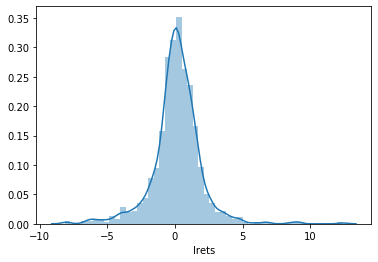

In [47]:
sns.distplot(amzn['lrets'].dropna())

In [48]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T) 
    sigma2 = np.zeros(T)   
    F = np.zeros(T)   
    v = np.zeros(T)   
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])     
        Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [49]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)  
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
    return Y 

         Current function value: 2.460892
         Iterations: 5
         Function evaluations: 282
         Gradient evaluations: 44


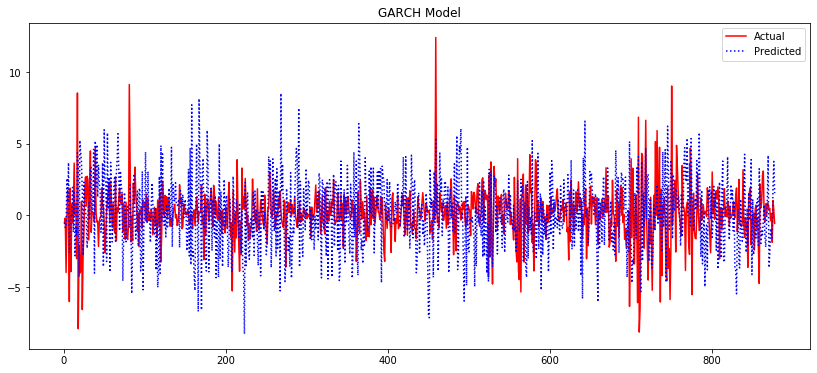

In [50]:
Y = amzn['lrets'].dropna()
T=len(Y)

#Y=np.random.normal(mu,sig,T)
param0=np.array([0.124,1.88,0.2,0.5])
param_star=minimize(GARCH,param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})
Y_GARCH=GARCH_Prod(param_star.x,Y[1],T)
timevec=np.linspace(1,T,T)

fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')

plt.legend(loc='upper right')
plt.title("GARCH Model")
plt.show()

In [51]:
diff = pd.DataFrame({'Actual':list(Y),
                     'Predicted':list(Y_GARCH)})

diff.head()


,Actual,Predicted
0,-0.503631,-0.503631
1,-0.180025,-0.855324
2,-3.984119,-0.814873
3,-0.146506,2.578114
4,1.745650,0.944713


In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(diff['Actual'],diff['Predicted']))
rms

3.0543426700646243

In [53]:
y_pred = [] * 1000

for i in range(len(diff)+1):
    if i == 0:
        y_pred.append(636.989990)
    else:
        y_pred.append(math.exp(diff['Predicted'][i-1]/100) * y_pred[i-1])

In [54]:
Predicted = pd.DataFrame({'Actual_Close_Price':amzn.Close,
                     'Predicted_Close_Price':list(y_pred),
                         'Date': amzn.Date})
Predicted.set_index('Date')
Predicted.head()

,Actual_Close_Price,Predicted_Close_Price,Date
0,636.989990,636.989990,2016-01-04
1,633.789978,633.789978,2016-01-05
2,632.650024,628.392134,2016-01-06
3,607.940002,623.292342,2016-01-07
4,607.049988,639.570461,2016-01-08


### Checking Return Volatility with Actual and Predicted Values

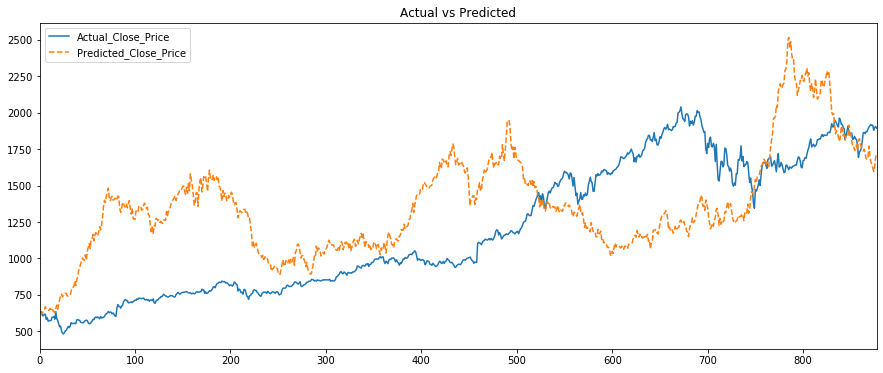

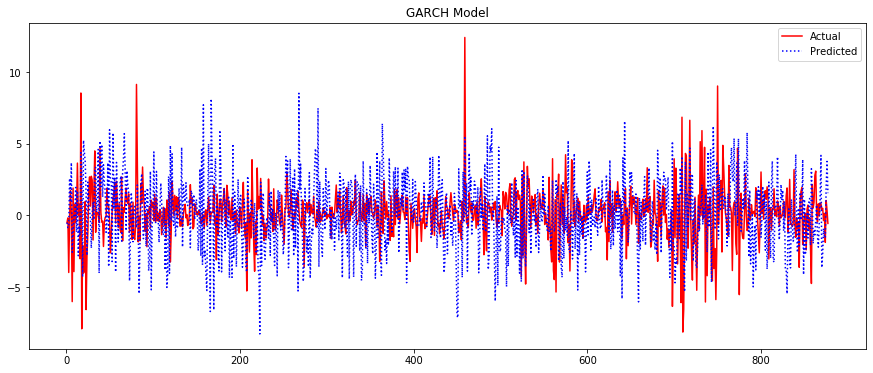

In [55]:

Predicted[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,6), style=['-','--'], 
                                                                    title = 'Actual vs Predicted')
fig= plt.figure(figsize=(15,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, Y_GARCH,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("GARCH Model")
plt.show()
            


In [56]:
Predicted.head(2)

,Actual_Close_Price,Predicted_Close_Price,Date
0,636.989990,636.989990,2016-01-04
1,633.789978,633.789978,2016-01-05


# Trading Strategy 
    # Buy if we have next days predicted_value greater than todays close value and hold if already bought 
    # Sell if we have next days predicted_value lesser than todays close value and dont buy until rule 1

In [57]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(Predicted)-1):
    if Predicted['Predicted_Close_Price'][i+1] > Predicted['Actual_Close_Price'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / Predicted['Actual_Close_Price'][i])
            balance = int(amount % Predicted['Actual_Close_Price'][i])
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:',Predicted['Actual_Close_Price'][i] ,'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            amount = portfolio + balance
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    elif Predicted['Predicted_Close_Price'][i+1] < Predicted['Actual_Close_Price'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * Predicted['Actual_Close_Price'][i]
            
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',Predicted['Actual_Close_Price'][i],'Action:',action[i],'Portfolio:',round(portfolio,2),'Stocks:', stocks,'Balance_init:',balance,'total($)',round(amount,2))
            Portfolio.append(round(portfolio,5))
            Amount.append(round(amount,0))
            Stocks.append(stocks)
            
    print('\n')
 
    

Stock: 636.98999 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 633.789978 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 632.650024 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 10000


Stock: 607.940002 Action: Buy Portfolio: 9727.04 Stocks: 16 Balance_init: 272 total($) 9999.04


Stock: 607.049988 Action: Bought--Holding Portfolio: 9712.8 Stocks: 16 Balance_init: 272 total($) 9984.8


Stock: 617.73999 Action: Bought--Holding Portfolio: 9883.84 Stocks: 16 Balance_init: 272 total($) 10155.84


Stock: 617.890015 Action: Bought--Holding Portfolio: 9886.24 Stocks: 16 Balance_init: 272 total($) 10158.24


Stock: 581.809998 Action: Bought--Holding Portfolio: 9308.96 Stocks: 16 Balance_init: 272 total($) 9580.96


Stock: 593.0 Action: Bought--Holding Portfolio: 9488.0 Stocks: 16 Balance_init: 272 total($) 9760.0


Stock: 570.179993 Action: Bo

Stock: 697.450012 Action: Bought--Holding Portfolio: 11159.2 Stocks: 16 Balance_init: 272 total($) 11431.2


Stock: 698.52002 Action: Bought--Holding Portfolio: 11176.32 Stocks: 16 Balance_init: 272 total($) 11448.32


Stock: 702.799988 Action: Bought--Holding Portfolio: 11244.8 Stocks: 16 Balance_init: 272 total($) 11516.8


Stock: 696.75 Action: Bought--Holding Portfolio: 11148.0 Stocks: 16 Balance_init: 272 total($) 11420.0


Stock: 704.200012 Action: Bought--Holding Portfolio: 11267.2 Stocks: 16 Balance_init: 272 total($) 11539.2


Stock: 708.349976 Action: Bought--Holding Portfolio: 11333.6 Stocks: 16 Balance_init: 272 total($) 11605.6


Stock: 714.909973 Action: Bought--Holding Portfolio: 11438.56 Stocks: 16 Balance_init: 272 total($) 11710.56


Stock: 712.23999 Action: Bought--Holding Portfolio: 11395.84 Stocks: 16 Balance_init: 272 total($) 11667.84


Stock: 722.789978 Action: Bought--Holding Portfolio: 11564.64 Stocks: 16 Balance_init: 272 total($) 11836.64


Stock: 719.440002

Stock: 784.47998 Action: Bought--Holding Portfolio: 12551.68 Stocks: 16 Balance_init: 272 total($) 12823.68


Stock: 784.059998 Action: Bought--Holding Portfolio: 12544.96 Stocks: 16 Balance_init: 272 total($) 12816.96


Stock: 760.140015 Action: Bought--Holding Portfolio: 12162.24 Stocks: 16 Balance_init: 272 total($) 12434.24


Stock: 771.48999 Action: Bought--Holding Portfolio: 12343.84 Stocks: 16 Balance_init: 272 total($) 12615.84


Stock: 761.01001 Action: Bought--Holding Portfolio: 12176.16 Stocks: 16 Balance_init: 272 total($) 12448.16


Stock: 761.090027 Action: Bought--Holding Portfolio: 12177.44 Stocks: 16 Balance_init: 272 total($) 12449.44


Stock: 769.690002 Action: Bought--Holding Portfolio: 12315.04 Stocks: 16 Balance_init: 272 total($) 12587.04


Stock: 778.52002 Action: Bought--Holding Portfolio: 12456.32 Stocks: 16 Balance_init: 272 total($) 12728.32


Stock: 775.099976 Action: Bought--Holding Portfolio: 12401.6 Stocks: 16 Balance_init: 272 total($) 12673.6


Stock: 


Stock: 771.400024 Action: Bought--Holding Portfolio: 12342.4 Stocks: 16 Balance_init: 272 total($) 12614.4


Stock: 772.130005 Action: Bought--Holding Portfolio: 12354.08 Stocks: 16 Balance_init: 272 total($) 12626.08


Stock: 765.150024 Action: Bought--Holding Portfolio: 12242.4 Stocks: 16 Balance_init: 272 total($) 12514.4


Stock: 749.869995 Action: Bought--Holding Portfolio: 11997.92 Stocks: 16 Balance_init: 272 total($) 12269.92


Stock: 753.669983 Action: Bought--Holding Portfolio: 12058.72 Stocks: 16 Balance_init: 272 total($) 12330.72


Stock: 757.179993 Action: Bought--Holding Portfolio: 12114.88 Stocks: 16 Balance_init: 272 total($) 12386.88


Stock: 780.450012 Action: Bought--Holding Portfolio: 12487.2 Stocks: 16 Balance_init: 272 total($) 12759.2


Stock: 795.98999 Action: Bought--Holding Portfolio: 12735.84 Stocks: 16 Balance_init: 272 total($) 13007.84


Stock: 796.919983 Action: Bought--Holding Portfolio: 12750.72 Stocks: 16 Balance_init: 272 total($) 13022.72


Stock: 

Stock: 980.789978 Action: Bought--Holding Portfolio: 15692.64 Stocks: 16 Balance_init: 272 total($) 15964.64


Stock: 976.469971 Action: Bought--Holding Portfolio: 15623.52 Stocks: 16 Balance_init: 272 total($) 15895.52


Stock: 964.169983 Action: Bought--Holding Portfolio: 15426.72 Stocks: 16 Balance_init: 272 total($) 15698.72


Stock: 987.710022 Action: Bought--Holding Portfolio: 15803.36 Stocks: 16 Balance_init: 272 total($) 16075.36


Stock: 995.169983 Action: Bought--Holding Portfolio: 15922.72 Stocks: 16 Balance_init: 272 total($) 16194.72


Stock: 992.590027 Action: Bought--Holding Portfolio: 15881.44 Stocks: 16 Balance_init: 272 total($) 16153.44


Stock: 1002.22998 Action: Bought--Holding Portfolio: 16035.68 Stocks: 16 Balance_init: 272 total($) 16307.68


Stock: 1001.299988 Action: Bought--Holding Portfolio: 16020.8 Stocks: 16 Balance_init: 272 total($) 16292.8


Stock: 1003.73999 Action: Bought--Holding Portfolio: 16059.84 Stocks: 16 Balance_init: 272 total($) 16331.84


St

Stock: 1186.0 Action: Bought--Holding Portfolio: 18976.0 Stocks: 16 Balance_init: 272 total($) 19248.0


Stock: 1195.829956 Action: Bought--Holding Portfolio: 19133.28 Stocks: 16 Balance_init: 272 total($) 19405.28


Stock: 1193.599976 Action: Bought--Holding Portfolio: 19097.6 Stocks: 16 Balance_init: 272 total($) 19369.6


Stock: 1161.27002 Action: Bought--Holding Portfolio: 18580.32 Stocks: 16 Balance_init: 272 total($) 18852.32


Stock: 1176.75 Action: Bought--Holding Portfolio: 18828.0 Stocks: 16 Balance_init: 272 total($) 19100.0


Stock: 1162.349976 Action: Bought--Holding Portfolio: 18597.6 Stocks: 16 Balance_init: 272 total($) 18869.6


Stock: 1133.949951 Action: Bought--Holding Portfolio: 18143.2 Stocks: 16 Balance_init: 272 total($) 18415.2


Stock: 1141.569946 Action: Bought--Holding Portfolio: 18265.12 Stocks: 16 Balance_init: 272 total($) 18537.12


Stock: 1152.349976 Action: Bought--Holding Portfolio: 18437.6 Stocks: 16 Balance_init: 272 total($) 18709.6


Stock: 1159.79

Stock: 1601.540039 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1576.119995 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1587.280029 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1581.76001 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1574.369995 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1585.459961 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1581.400024 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1601.859985 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1603.069946 Action: Price-Prediction-Already-Lower Portfol

Stock: 1782.170044 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1642.810059 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1538.880005 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1530.420044 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1598.01001 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1665.530029 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1665.530029 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1627.800049 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26162.18


Stock: 1642.810059 Action: Price-Prediction-Already-Lower Portfol

Stock: 1843.060059 Action: Bought--Holding Portfolio: 33175.08 Stocks: 18 Balance_init: 1517 total($) 34692.08


Stock: 1844.869995 Action: Bought--Holding Portfolio: 33207.66 Stocks: 18 Balance_init: 1517 total($) 34724.66


Stock: 1863.040039 Action: Bought--Holding Portfolio: 33534.72 Stocks: 18 Balance_init: 1517 total($) 35051.72


Stock: 1864.819946 Action: Bought--Holding Portfolio: 33566.76 Stocks: 18 Balance_init: 1517 total($) 35083.76


Stock: 1861.689941 Action: Bought--Holding Portfolio: 33510.42 Stocks: 18 Balance_init: 1517 total($) 35027.42


Stock: 1887.310059 Action: Bought--Holding Portfolio: 33971.58 Stocks: 18 Balance_init: 1517 total($) 35488.58


Stock: 1923.77002 Action: Bought--Holding Portfolio: 34627.86 Stocks: 18 Balance_init: 1517 total($) 36144.86


Stock: 1901.75 Action: Bought--Holding Portfolio: 34231.5 Stocks: 18 Balance_init: 1517 total($) 35748.5


Stock: 1902.25 Action: Bought--Holding Portfolio: 34240.5 Stocks: 18 Balance_init: 1517 total($) 35757.

### Create a Dataframe with all Information

In [58]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price':amzn.Close[1:],
                                 'Predicted_Close_Price':list(y_pred[1:]),
                                 'Date': amzn.Date[1:],
                                 'Action':  action,
                                 'Stocks': Stocks,
                                 'Portfolio($)': Portfolio,
                                 'Amount($)':Amount
                                    })

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Stocks,Portfolio($),Amount($)
1,633.789978,633.789978,2016-01-05,Price-Prediction-Already-Lower,0,0.00000,10000.0
2,632.650024,628.392134,2016-01-06,Price-Prediction-Already-Lower,0,0.00000,10000.0
3,607.940002,623.292342,2016-01-07,Price-Prediction-Already-Lower,0,0.00000,10000.0
4,607.049988,639.570461,2016-01-08,Buy,16,9727.04003,9999.0
5,617.739990,645.641199,2016-01-11,Bought--Holding,16,9712.79981,9985.0


### Profit Made with this Strategy 

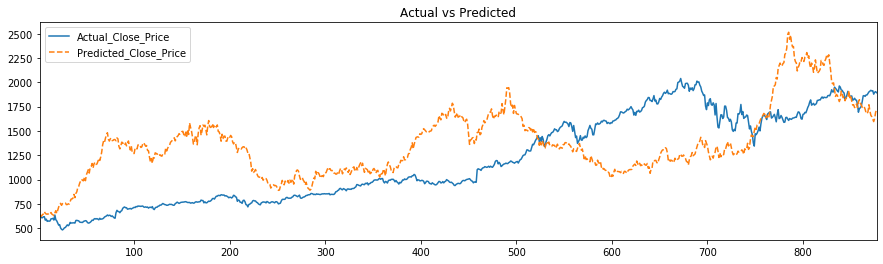

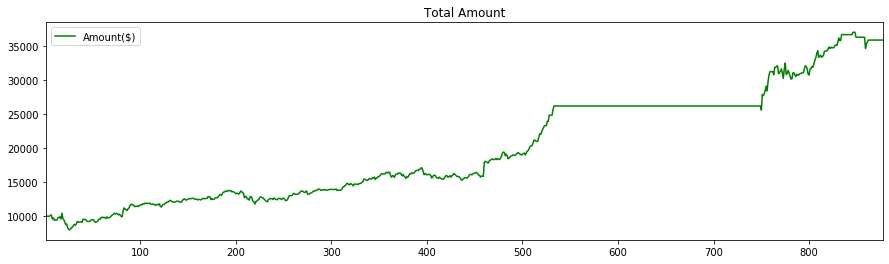

In [59]:
Strategy_Result[['Actual_Close_Price','Predicted_Close_Price']].loc[0:].plot(figsize=(15,4), 
                                                                             style=['-','--'], 
                                                                             title = 'Actual vs Predicted')


Strategy_Result[['Amount($)']].loc[0:].plot(figsize=(15,4), 
                                            style=['-g'], 
                                            title = 'Total Amount')

In [60]:
Profit = (Amount[-1])/10000
print('Initial_Investment : 10000$')
print('Final Amount:',Amount[-1],'$')      
print ('Profit_Percent:',Profit*100,'%')


Initial_Investment : 10000$
Final Amount: 35828.0 $
Profit_Percent: 358.28000000000003 %


In [61]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))
rms

464.86842606940047

### Sharpe Ratio

In [62]:
Strategy_Result['Returns'] = Strategy_Result['Amount($)'].pct_change()



In [63]:
mean_returns = Strategy_Result['Returns'].mean()
sd = Strategy_Result['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(877)*(mean_returns)/sd
Sharpe_Ratio



0.0015489932777190026 0.013595880408152095


3.3739760380802806

In [64]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(Strategy_Result['Actual_Close_Price'], Strategy_Result['Predicted_Close_Price']))

In [65]:
sqrt(rms)

21.560807639543572

# Kalman Filter

In [66]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import sqrt

In [67]:
def Kalman_Filter(Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = param0[0]
    T = param0[1]
    H = param0[2]
    Q = param0[3]
    # "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    KF_Dens = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
            Likelihood = np.sum(KF_Dens[1:-1])  
            return Likelihood

In [68]:
def Kalman_Smoother(params, Y):
    S = Y.shape[0]
    S = S + 1
    "Initialize Params:"
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3]
    "Kalman Filter Starts:"
    u_predict = np.zeros(S)
    u_update = np.zeros(S)
    P_predict = np.zeros(S)
    P_update = np.zeros(S)
    v = np.zeros(S)
    F = np.zeros(S)
    for s in range(1,S):
        if s == 1: 
            P_update[s] = 1000
            P_predict[s] =  T*P_update[1]*np.transpose(T)+Q    
        else: 
            # "Please fill this part."
            F[s]= Z*P_predict[s-1]*np.transpose(Z)+H
            v[s] = Y[s-1] - Z*u_predict[s-1]
            u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
            u_predict[s] = T*u_predict[s];
            P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
            P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    
            u_smooth = np.zeros(S)
            P_smooth = np.zeros(S)
            u_smooth[S-1] = u_update[S-1]
            P_smooth[S-1] = P_update[S-1]    
    for  t in range(S-1,0,-1):
     
        u_smooth[t-1] = u_update[t] +P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]- T*u_update[t])
        P_smooth[t-1] = P_update[t] + (P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_update[t])/P_update[t]*T*P_update[t])
    
    u_smooth = u_smooth[0:-1]
    return u_smooth

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


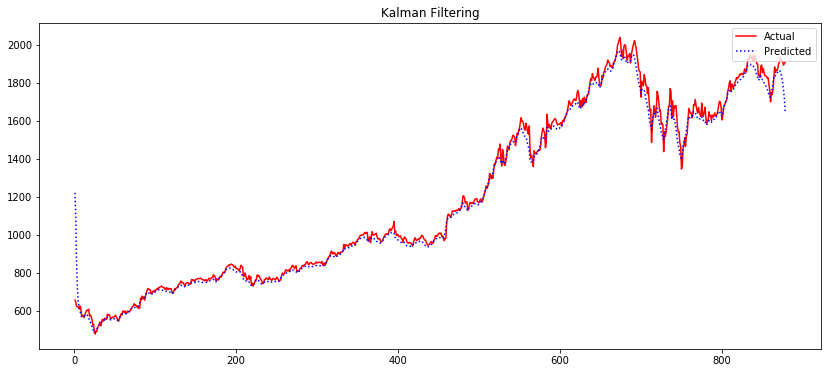

In [70]:
Y = amzn['Open']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, u,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 6
         Gradient evaluations: 1


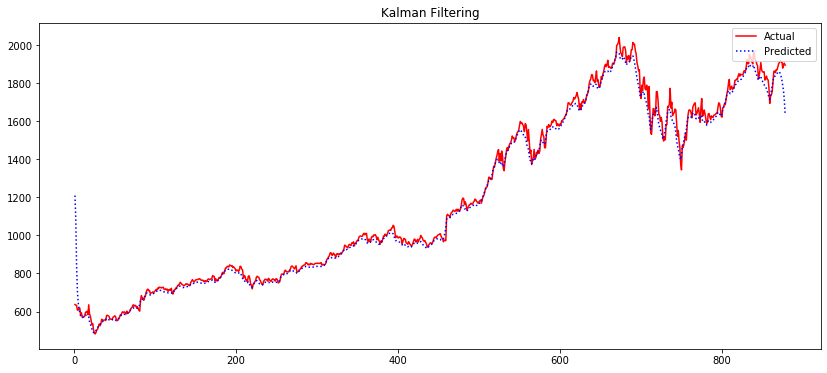

In [71]:
Y = amzn['Close']
T = Y.shape[0]
mu = 1196;


param0 = np.array([0.3, 0.9, 0.8, 1.1])
param_star = minimize(Kalman_Filter, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
u = Kalman_Smoother(param_star.x, Y)

timevec = np.linspace(1,T,T)


fig= plt.figure(figsize=(14,6))
plt.plot(timevec, Y,'r-', label='Actual')
plt.plot(timevec, u,'b:', label='Predicted')
plt.legend(loc='upper right')
plt.title("Kalman Filtering")
plt.show()

In [79]:
results = pd.DataFrame({'Actual': list(Y),
                  'Predicted' : list(u),
                  'Date':amzn['Date'],
                  'Open':amzn['Open'],
                  'Close':amzn['Close']
                       })


In [80]:
results.set_index('Date',inplace = True)
results.head(10)

,Actual,Predicted,Open,Close
Date,,,,
2016-01-04,636.989990,1209.211922,656.289978,636.989990
2016-01-05,633.789978,1089.768655,646.859985,633.789978
2016-01-06,632.650024,841.790046,622.000000,632.650024
2016-01-07,607.940002,708.527672,621.799988,607.940002
2016-01-08,607.049988,646.379101,619.659973,607.049988
2016-01-11,617.739990,615.485064,612.479980,617.739990
2016-01-12,617.890015,594.158485,625.250000,617.890015
2016-01-13,581.809998,576.568643,620.880005,581.809998
2016-01-14,593.000000,573.710622,580.250000,593.000000


# Long Short Day trading:
#if predicted > yesterdays close, buy and sell at end of day
#if predicted < yesterdays close, sell and buy at end of day

In [81]:
amount = 10000
signal = 0
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []

for i in range(len(results)):
    if results['Predicted'][i] > results['Actual'][i-1]:
        action.append('Buy at Open')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Buy at Open',round(portfolio,2),stocks,round(balance,2))
        
        
        action.append('Sell at End')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Sell at Close',round(amount,2),balance)
        Amount.append(amount)
        
    else:
        action.append('Sell at Open')
        stocks = int(amount/results['Open'][i])
        balance = int(amount%results['Close'][i])
        portfolio = stocks * results ['Open'][i]
        print(i,'Sell at Open',round(portfolio,2),'-',stocks,round(balance,2))
        
        
        action.append('Buy at Close')
        portfolio = stocks * results['Close'][i]
        signal = 0
        stocks = 0
        amount = balance + portfolio
        portfolio = 0
        balance = 0
        print(i,'Buy Back at Close',round(amount,2),balance)
        Amount.append(amount)
    print('\n')
        

0 Sell at Open 9844.35 - 15 445
0 Buy Back at Close 9999.85 0


1 Buy at Open 9702.9 15 493
1 Sell at Close 9999.85 0


2 Buy at Open 9952.0 16 510
2 Sell at Close 10632.4 0


3 Buy at Open 10570.6 17 297
3 Sell at Close 10631.98 0


4 Buy at Open 10534.22 17 312
4 Sell at Close 10631.85 0


5 Buy at Open 10412.16 17 130
5 Sell at Close 10631.58 0


6 Sell at Open 10629.25 - 17 127
6 Buy Back at Close 10631.13 0


7 Sell at Open 10554.96 - 17 158
7 Buy Back at Close 10048.77 0


8 Sell at Open 9864.25 - 17 560
8 Buy Back at Close 10641.0 0


9 Sell at Open 10300.32 - 18 377
9 Buy Back at Close 10640.24 0


10 Sell at Open 10387.62 - 18 299
10 Buy Back at Close 10639.64 0


11 Sell at Open 10158.48 - 18 347
11 Buy Back at Close 10638.86 0


12 Buy at Open 10324.44 18 288
12 Sell at Close 10638.36 0


13 Buy at Open 10597.14 18 499
13 Sell at Close 11233.84 0


14 Sell at Open 10763.82 - 18 496
14 Buy Back at Close 11233.54 0


15 Sell at Open 10862.1 - 18 411
15 Buy Back at Close 11233.

152 Sell at Open 10777.2 - 14 495
152 Buy Back at Close 11254.84 0


153 Sell at Open 10779.16 - 14 457
153 Buy Back at Close 11254.36 0


154 Sell at Open 10758.44 - 14 438
154 Buy Back at Close 11253.84 0


155 Sell at Open 10806.6 - 14 494
155 Buy Back at Close 11252.86 0


156 Sell at Open 10760.68 - 14 556
156 Buy Back at Close 11252.56 0


157 Sell at Open 10701.74 - 14 547
157 Buy Back at Close 11251.82 0


158 Sell at Open 10696.0 - 14 549
158 Buy Back at Close 11251.44 0


159 Sell at Open 10666.6 - 14 649
159 Buy Back at Close 11251.34 0


160 Sell at Open 10605.0 - 14 618
160 Buy Back at Close 11250.72 0


161 Sell at Open 10686.34 - 14 576
161 Buy Back at Close 11250.3 0


162 Sell at Open 10682.0 - 14 648
162 Buy Back at Close 11249.5 0


163 Sell at Open 10584.0 - 14 620
163 Buy Back at Close 11249.08 0


164 Sell at Open 10640.7 - 14 483
164 Buy Back at Close 11249.0 0


165 Sell at Open 10762.08 - 14 450
165 Buy Back at Close 11248.06 0


166 Sell at Open 10794.7 - 14 5

290 Sell at Open 10217.4 - 12 450
290 Buy Back at Close 10590.48 0


291 Sell at Open 10236.6 - 12 353
291 Buy Back at Close 10589.96 0


292 Sell at Open 10236.96 - 12 403
292 Buy Back at Close 10589.92 0


293 Sell at Open 10166.4 - 12 391
293 Buy Back at Close 10589.56 0


294 Sell at Open 10142.76 - 12 430
294 Buy Back at Close 10589.32 0


295 Sell at Open 10145.76 - 12 437
295 Buy Back at Close 10589.24 0


296 Sell at Open 10176.0 - 12 383
296 Buy Back at Close 10589.0 0


297 Sell at Open 10212.0 - 12 353
297 Buy Back at Close 10589.0 0


298 Sell at Open 10284.0 - 12 359
298 Buy Back at Close 10588.52 0


299 Sell at Open 10221.24 - 12 333
299 Buy Back at Close 10588.08 0


300 Sell at Open 10242.6 - 12 357
300 Buy Back at Close 10587.36 0


301 Sell at Open 10251.96 - 12 351
301 Buy Back at Close 10586.64 0


302 Sell at Open 10263.6 - 12 345
302 Buy Back at Close 10586.04 0


303 Sell at Open 10241.88 - 12 358
303 Buy Back at Close 10585.72 0


304 Sell at Open 10218.12 - 12

428 Buy Back at Close 13436.73 0


429 Sell at Open 12909.13 - 13 608
429 Buy Back at Close 13436.27 0


430 Sell at Open 12875.2 - 13 771
430 Buy Back at Close 13435.47 0


431 Sell at Open 12704.25 - 13 827
431 Buy Back at Close 13435.18 0


432 Sell at Open 12633.27 - 13 783
432 Buy Back at Close 13434.73 0


433 Sell at Open 12627.03 - 13 894
433 Buy Back at Close 13434.45 0


434 Sell at Open 12493.13 - 13 63
434 Buy Back at Close 12479.3 0


435 Sell at Open 12341.03 - 13 262
435 Buy Back at Close 12479.27 0


436 Sell at Open 12291.37 - 13 277
436 Buy Back at Close 12478.8 0


437 Buy at Open 12324.0 13 117
437 Sell at Close 12478.31 0


438 Sell at Open 12374.18 - 13 45
438 Buy Back at Close 12478.2 0


439 Sell at Open 11521.32 - 12 942
439 Buy Back at Close 12478.2 0


440 Sell at Open 11568.0 - 12 8
440 Buy Back at Close 11518.28 0


441 Sell at Open 11496.0 - 12 33
441 Buy Back at Close 11518.2 0


442 Buy at Open 11450.52 12 898
442 Sell at Close 12483.4 0


443 Buy at Ope

568 Sell at Open 12869.73 - 9 311
568 Buy Back at Close 12958.07 0


569 Buy at Open 12825.27 9 303
569 Sell at Close 12957.72 0


570 Buy at Open 12887.91 9 31
570 Sell at Close 12956.98 0


571 Sell at Open 12954.96 - 9 113
571 Buy Back at Close 12956.45 0


572 Buy at Open 12955.5 9 1368
572 Sell at Close 14404.5 0


573 Sell at Open 13042.26 - 9 96
573 Buy Back at Close 12973.11 0


574 Buy at Open 11560.0 8 1441
574 Sell at Close 12973.0 0


575 Buy at Open 11698.4 8 942
575 Sell at Close 12972.64 0


576 Sell at Open 12117.2 - 8 749
576 Buy Back at Close 12971.72 0


577 Sell at Open 12345.76 - 8 516
577 Buy Back at Close 12971.28 0


578 Sell at Open 12489.6 - 8 751
578 Buy Back at Close 12970.92 0


579 Sell at Open 12373.52 - 8 828
579 Buy Back at Close 12970.88 0


580 Sell at Open 12286.4 - 8 1290
580 Buy Back at Close 12970.72 0


581 Buy at Open 11664.0 8 1289
581 Sell at Close 12970.36 0


582 Buy at Open 11880.08 8 826
582 Sell at Close 12969.68 0


583 Buy at Open 11438

707 Buy Back at Close 16768.3 0


708 Sell at Open 15963.3 - 9 126
708 Buy Back at Close 15103.8 0


709 Sell at Open 13626.72 - 8 846
709 Buy Back at Close 15103.36 0


710 Sell at Open 14846.31 - 9 318
710 Buy Back at Close 15103.29 0


711 Sell at Open 14940.0 - 9 1253
711 Buy Back at Close 15102.92 0


712 Buy at Open 14861.6 10 1329
712 Sell at Close 16633.2 0


713 Buy at Open 15699.9 10 653
713 Sell at Close 16633.1 0


714 Buy at Open 16235.3 10 1643
714 Sell at Close 18298.3 0


715 Sell at Open 16785.9 - 10 1642
715 Buy Back at Close 18297.3 0


716 Sell at Open 18233.27 - 11 391
716 Buy Back at Close 18296.8 0


717 Buy at Open 17801.85 11 225
717 Sell at Close 18295.91 0


718 Buy at Open 16730.0 10 741
718 Sell at Close 18295.9 0


719 Sell at Open 17550.0 - 10 746
719 Buy Back at Close 18295.1 0


720 Sell at Open 17325.0 - 10 1170
720 Buy Back at Close 18294.3 0


721 Sell at Open 16982.4 - 10 288
721 Buy Back at Close 16656.5 0


722 Sell at Open 16492.9 - 10 344
722 Bu

847 Sell at Open 13201.58 - 7 157
847 Buy Back at Close 13509.99 0


848 Sell at Open 13251.35 - 7 426
848 Buy Back at Close 13509.0 0


849 Sell at Open 12968.83 - 7 496
849 Buy Back at Close 13508.79 0


850 Sell at Open 13123.53 - 7 506
850 Buy Back at Close 13508.64 0


851 Sell at Open 12962.46 - 7 490
851 Buy Back at Close 13507.76 0


852 Sell at Open 12856.13 - 7 799
852 Buy Back at Close 13507.36 0


853 Sell at Open 12851.23 - 7 744
853 Buy Back at Close 13506.96 0


854 Sell at Open 12829.25 - 7 651
854 Buy Back at Close 13506.01 0


855 Sell at Open 12761.84 - 7 771
855 Buy Back at Close 13505.33 0


856 Sell at Open 12778.43 - 7 791
856 Buy Back at Close 13505.24 0


857 Sell at Open 12530.07 - 7 1079
857 Buy Back at Close 13504.49 0


858 Sell at Open 12320.07 - 7 1655
858 Buy Back at Close 13503.83 0


859 Buy at Open 11894.68 7 1396
859 Sell at Close 13502.92 0


860 Buy at Open 12247.2 7 1333
860 Sell at Close 13502.5 0


861 Buy at Open 12163.97 7 1221
861 Sell at Clo

In [82]:
results['Amount'] = list(Amount)

In [83]:
results['Returns'] = results['Amount'].pct_change()

In [84]:
results.tail()

,Actual,Predicted,Open,Close,Amount,Returns
Date,,,,,,
2019-06-24,1913.900024,1815.324734,1912.660034,1913.900024,11578.400144,-0.000035
2019-06-25,1878.270020,1785.700365,1911.839966,1878.270020,11577.620120,-0.000067
2019-06-26,1897.829956,1758.574720,1892.479980,1897.829956,11576.979736,-0.000055
2019-06-27,1904.280029,1709.819072,1902.000000,1904.280029,11576.680174,-0.000026
2019-06-28,1893.630005,1635.343001,1909.099976,1893.630005,11575.780030,-0.000078


In [85]:
mean_returns = results['Returns'].mean()
sd = results['Returns'].std()
print(mean_returns,sd)
Market_RF = 0.0464


Sharpe_Ratio = np.sqrt(878)*(mean_returns)/sd
Sharpe_Ratio

0.0005653884599063233 0.028321589688019767


0.5915297222340672

In [86]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(results['Actual'], results['Predicted']))
rms

41.47427049927625